In [ ]:
#%pip install -r requirements.txt

In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import cross_validate, validation_curve, train_test_split, cross_val_predict,cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from mlxtend.evaluate import bias_variance_decomp
plt.rcParams['figure.figsize'] = (16, 4)

In [167]:
df = pd.read_csv("datasets/data2.csv")
print(df.shape)

(1460, 81)


In [7]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
import io
buffer = io.StringIO()
df.info(buf=buffer)
s = buffer.getvalue()
with open("df_info.txt", "w", encoding="utf-8") as f:
    f.write(s)

In [9]:
drop_columns = ["Id", "Alley", "MasVnrType", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]
df = df.drop(drop_columns, axis=1)
df = df.dropna()
print(df.shape)

(1094, 74)


In [10]:
y = df["SalePrice"]
df = df.drop("SalePrice", axis=1)

In [11]:
standart_scaler = StandardScaler()
y = standart_scaler.fit_transform(y.values.reshape(-1,1)).reshape(-1)

In [12]:
class autoLabelEncoder:
    def __init__(self) -> None:
        self.cat_encoders:dict = {}

    def fit(self, data:pd.DataFrame, categories:list[str]) -> None:
        for feat in categories:
            enc = LabelEncoder()
            self.cat_encoders[feat] = enc.fit(data.loc[data[feat].notna(), feat])

    def transform(self, data:pd.DataFrame, categories:list[str]) -> pd.DataFrame:
        for feat in categories:
            if(feat in data.columns):
                enc = self.cat_encoders[feat]
                data.loc[data[feat].notna(), feat] = (enc.transform(data.loc[data[feat].notna(), feat]))
                data[feat] = data[feat].astype(int)
        return data
    
    def get_encoder(self, category) -> LabelEncoder:
        return self.cat_encoders[category]


In [13]:
objs = df.select_dtypes(include='object')
le = autoLabelEncoder()
le.fit(df, objs)
df = le.transform(df, objs)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=1)

In [14]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,3,3,0,4,0,...,61,0,0,0,0,0,2,2008,8,4
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,0,5,2007,8,4
2,60,3,68.0,11250,1,0,3,0,4,0,...,42,0,0,0,0,0,9,2008,8,4
3,70,3,60.0,9550,1,0,3,0,0,0,...,35,272,0,0,0,0,2,2006,8,0
4,60,3,84.0,14260,1,0,3,0,2,0,...,84,0,0,0,0,0,12,2008,8,4


# 1. Выделите обучающую и отложенную выборку. Рассмотрим индивидуальные деревья (4 балла)

### a. Выполните 5-кратную перекрестную проверку, чтобы определить, какой будет наилучшая максимальная глубина для одного дерева регрессии, используя все признаки обучающего набора.

In [ ]:
scoring = {'mse': make_scorer(mean_squared_error)}

for depth in range(1,15):
    tree = DecisionTreeRegressor(max_depth=depth, random_state=1)
    print(str(depth) + ":", np.mean(cross_validate(tree,X_train,y_train,cv=5,scoring=scoring)["test_mse"]))

1: 0.5434616474570282
2: 0.39451545101555513
3: 0.32012193889352714
4: 0.2737327837927828
5: 0.28451186311286286
6: 0.2856325298942434
7: 0.29156848672128993
8: 0.30643535391955046
9: 0.307991388785556
10: 0.311526089828445
11: 0.2839907104489118
12: 0.3133558370664691
13: 0.2845165441330303
14: 0.30078149841722784


[]

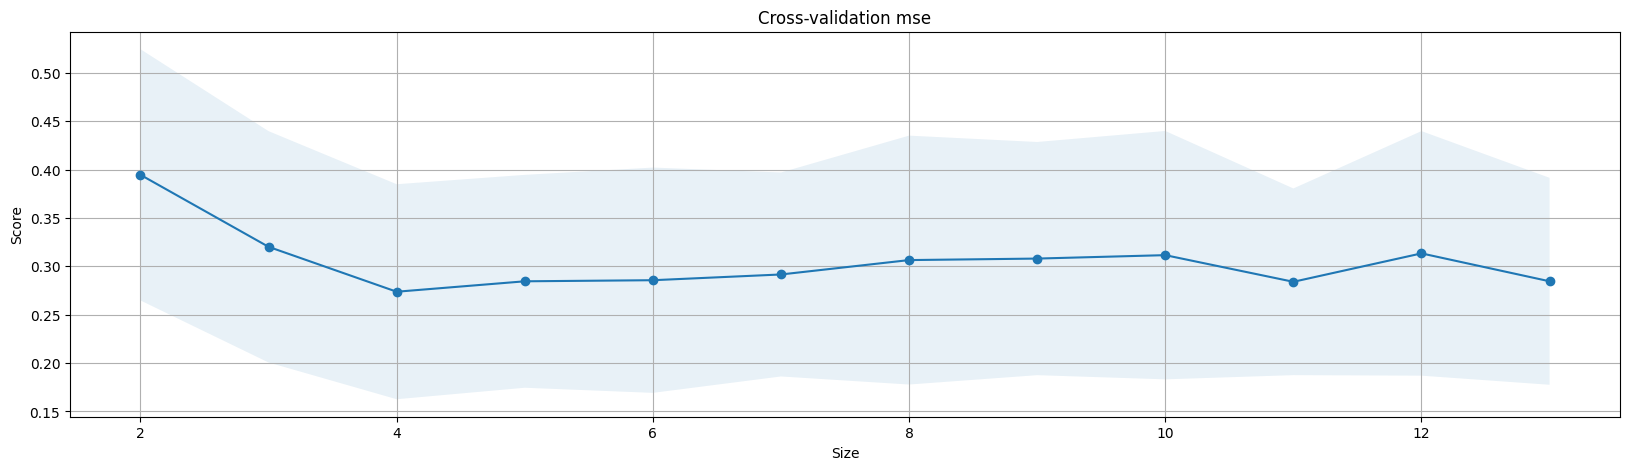

In [ ]:
tree = DecisionTreeRegressor(random_state=1)

max_depth_range = list(range(2, 14, 1))
scoring = make_scorer(mean_squared_error)

train_scores, test_scores = validation_curve(
        tree,
        X_train, y_train,
        param_name="max_depth",
        scoring=scoring,
        param_range=max_depth_range,
        cv=5)


def plot_validation_curve(X, y, err, axes = None, x_lab = "", y_lab = "", title = ""):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))
    
    axes.grid()
    axes.plot(X, y, "o-")
    axes.fill_between(
        X,
        y - err,
        y + err,
        alpha=0.1,
    )
    axes.set_xlabel(x_lab)
    axes.set_ylabel(y_lab)
    axes.set_title(title)

    return plt

plot_validation_curve(max_depth_range, np.mean(test_scores, axis=1), np.std(test_scores, axis=1), x_lab="Size", y_lab="Score", title="Cross-validation mse").plot()

### b. Визуализируйте предсказания со средними отклонениями +/- 1 стандартное отклонение во всех наборах перекрестной проверки.

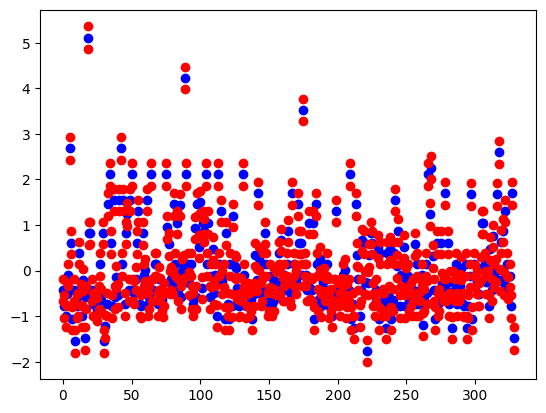

In [ ]:
from sklearn.metrics import mean_squared_error

tree = DecisionTreeRegressor(max_depth=8, random_state=1)
tree.fit(X_train,y_train)
pred = tree.predict(X_test)
err = mean_squared_error(pred, y_test)

a = np.arange(0,len(pred),1)
plt.plot(a, pred,'bo')
plt.plot(a, pred-err,'ro')
plt.plot(a, pred+err,'ro',)

In [ ]:
max_depth = 26
step=5

arr = np.arange(1,max_depth,step).astype(np.float32)

c=0
#arr = []

for i in range(1, max_depth, step):
    tree = DecisionTreeRegressor(max_depth=i, random_state=1)
    tree.fit(X_train,y_train)
    #arr.append(mean_squared_error(tree.predict(X_test),y_test))
    arr[c]=mean_squared_error(tree.predict(X_test),y_test)
    c+=1

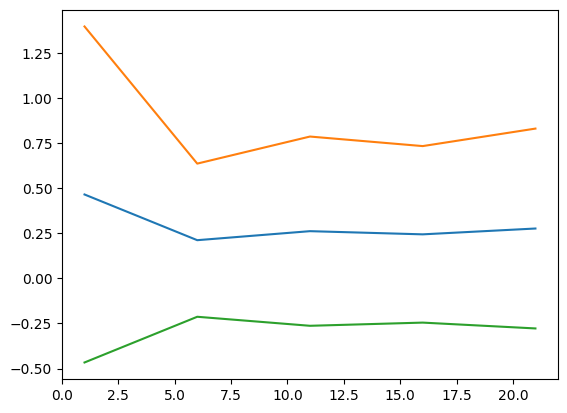

In [ ]:
a = np.arange(1,max_depth,step).astype(np.int16)

plt.plot(a,  arr)
plt.plot(a, 3*arr)
plt.plot(a, -1*arr)

### c. Постройте зависимость точности (+/- 2 стандартных отклонения) от числа деревьев

[]

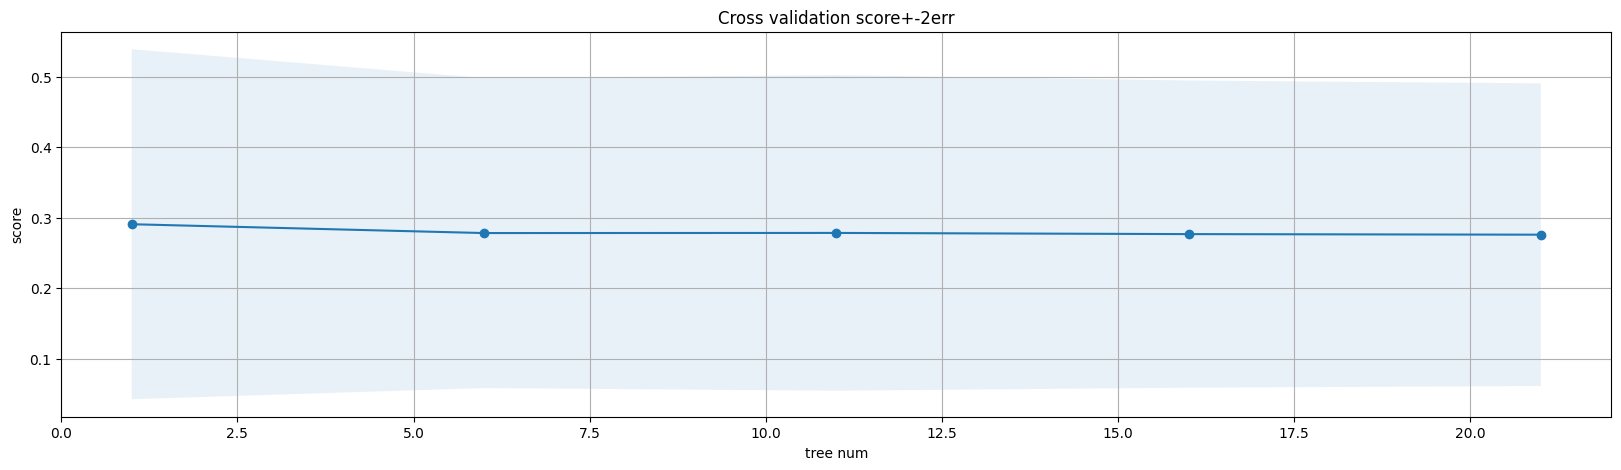

In [ ]:
random_fr = RandomForestRegressor(max_depth=6, bootstrap=False, random_state=1)

max_depth_range = list(range(1, 26, 5))
scoring = make_scorer(mean_squared_error)
train_scores, test_scores = validation_curve(
        random_fr,
        X_train, y_train,
        param_name="n_estimators",
        scoring=scoring,
        param_range=max_depth_range,
        cv=5)

err2 = 2*np.std(test_scores, axis=1)

plot_validation_curve(max_depth_range, np.mean(test_scores,axis=1), err2, title="Cross validation score+-2err" , x_lab = "tree num", y_lab = "score").plot()

### d. Визуализируйте предсказания на отложенной выборке. Можно ли получить интервальные предсказания и для нее?

model.predict(X_test) +- mean_squared_error(X_train, y_train)

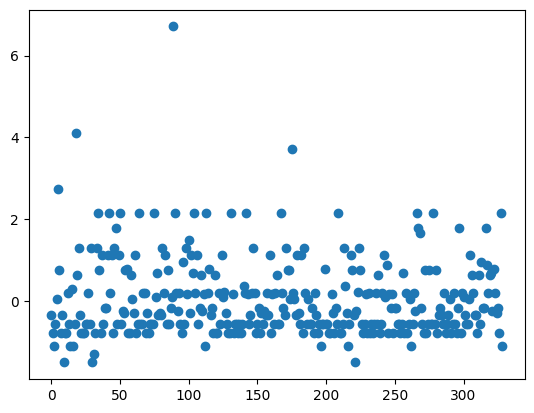

In [ ]:
rr = DecisionTreeRegressor(max_depth=6, random_state=1)
pred = rr.fit(X_train,y_train).predict(X_test)
plt.plot(np.arange(0,len(pred),1),pred,'o')

# 2. Перейдите к беггингу. C помощью кросс-валидации постройте и обучите несколько отдельных деревьев (4 балла).

### a. Подведите итоги работы каждого из отдельных деревьев (как численно, так и визуально) с помощью R^2. Как они работают в среднем?

In [ ]:
tree_num = 10

My_array = np.arange(tree_num*3).reshape(tree_num, 3).astype(np.float32)

tree = DecisionTreeRegressor(min_samples_leaf=1, max_depth=5) #, random_state=1

for i in range(tree_num):
    cv = cross_validate(tree, X_train, y_train, cv=5, scoring="r2")
    My_array[i] = i, np.mean(cv["test_score"]), np.var(cv["test_score"])

0.7310025
0.0029581822


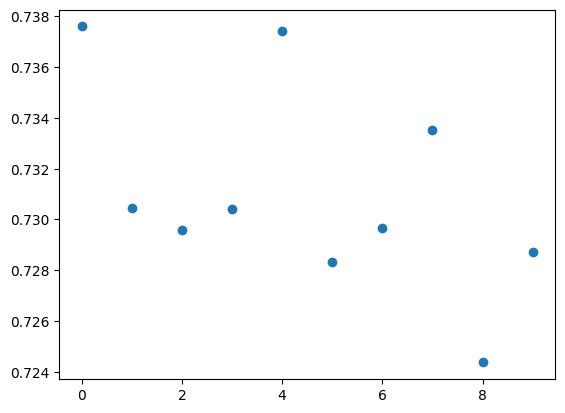

In [ ]:
My_arr2 = My_array.transpose(1, 0)

x  = My_arr2[0]
errors = My_arr2[1]
varianses = My_arr2[2]

print(np.mean(errors))
print(np.mean(varianses))
plt.plot(np.arange(0,len(errors),1), errors, 'o')

### b. Объедините деревья в один прогноз с помощью беггинга и оцените его с помощью R^2. Улучшились ли результаты? Оцените, как будет меняться точность в зависимости от глубины. Используйте не только среднее предсказание, но и дисперсию.

In [ ]:
for depth in range(1, 6):
    tree = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=1)
    
    br_tree = BaggingRegressor(tree, n_estimators=20, random_state=1)
    
    cv = cross_validate(br_tree, X_train, y_train, cv=5, scoring="r2")
    mean_score = np.mean(cv["test_score"])
    var_score = np.var(cv["test_score"])

    print("Depth:", depth)
    print("  Mean:", mean_score)
    print("  Var:", var_score)

Depth: 1
  Mean: 0.48735853176433397
  Var: 0.005108644157043171
Depth: 2
  Mean: 0.6636977250915187
  Var: 0.00326968351590374
Depth: 3
  Mean: 0.7283747531147905
  Var: 0.003967277573209955
Depth: 4
  Mean: 0.7765171980015619
  Var: 0.0036149406191554115
Depth: 5
  Mean: 0.794228503480076
  Var: 0.0032837610098167013


### c. Постройте графики зависимости bias-variance в зависимости от числа деревьев (до 500 деревьев)

In [ ]:
max_tree_num = 501
step=50

tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=2)

My_array = np.arange(1, (max_tree_num-1)*3, step).reshape(max_tree_num//step, 3).astype(np.float32)
c=0
for i in range(1,501,50):
    br_tree = BaggingRegressor(tree, n_estimators=i)

    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    
    _, bias, var = bias_variance_decomp(br_tree, X_train_sub.values, y_train_sub, X_test_sub.values, y_test_sub, loss='mse', num_rounds=10, random_seed=1)
    My_array[c] = (i, bias, var)
    c+=1

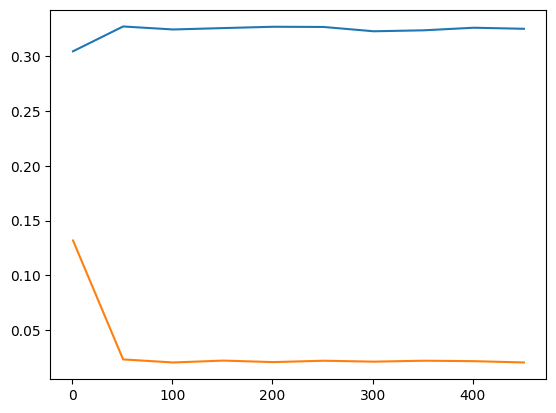

In [ ]:
My_arr2 = My_array.transpose(1, 0)
x = My_arr2[0]
biases = My_arr2[1]
vars = My_arr2[2]

plt.plot(x, biases)
plt.plot(x, vars)
#plt.plot()

# 3. Повторите предыдущие шаги, но для случайного леса (4 балла). Можете использовать любую из опций из oob_score и кросс-валидации. Объясните свой выбор.

### 2.a Подведите итоги работы каждого из отдельных деревьев (как численно, так и визуально) с помощью R^2. Как они работают в среднем?

In [ ]:
tree_num = 10

My_array = np.arange(tree_num*3).reshape(tree_num, 3).astype(np.float32)

tree = DecisionTreeRegressor(min_samples_leaf=1, max_depth=5) #, random_state=1

for i in range(tree_num):
    cv = cross_validate(tree, X_train, y_train, cv=5, scoring="r2")
    My_array[i] = i, np.mean(cv["test_score"]), np.var(cv["test_score"])

0.7313616
0.0028207763


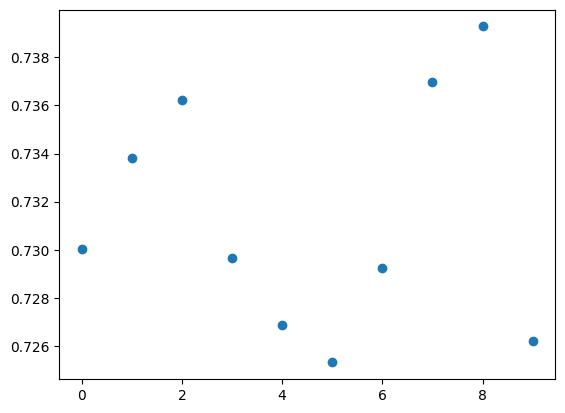

In [ ]:
My_arr2 = My_array.transpose(1, 0)

x  = My_arr2[0]
errors = My_arr2[1]
varianses = My_arr2[2]

print(np.mean(errors))
print(np.mean(varianses))
plt.plot(np.arange(0,len(errors),1), errors, 'o')

### 2.b. Объедините деревья в один прогноз с помощью беггинга и оцените его с помощью R^2. Улучшились ли результаты? Оцените, как будет меняться точность в зависимости от глубины. Используйте не только среднее предсказание, но и дисперсию.

In [ ]:
for depth in range(1, 6):
    rf_tree = RandomForestRegressor(n_estimators=50, max_depth=depth, random_state=1, min_samples_leaf=5)
    
    cv = cross_validate(rf_tree, X_train, y_train, cv=5, scoring="r2")
    mean_score = np.mean(cv["test_score"])
    var_score = np.var(cv["test_score"])

    print("Depth:", depth)
    print("  Mean:", mean_score)
    print("  Var:", var_score)

Depth: 1
  Mean: 0.5002780988641845
  Var: 0.005492408528378312
Depth: 2
  Mean: 0.68631781361058
  Var: 0.003356436043085679
Depth: 3
  Mean: 0.7508207717867136
  Var: 0.0036333688922035373
Depth: 4
  Mean: 0.7922704671811122
  Var: 0.0035028268162700118
Depth: 5
  Mean: 0.8093516423788054
  Var: 0.0033445623159437813


### 2.c. Постройте графики зависимости bias-variance в зависимости от числа деревьев (до 500 деревьев)

In [ ]:
max_tree_num = 201
step=50

tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=2)

My_array = np.arange(1, (max_tree_num-1)*3, step).reshape(max_tree_num//step, 3).astype(np.float32)
c=0
for i in range(1,max_tree_num,step):
    rf_tree = RandomForestRegressor(n_estimators=i,max_depth=3)

    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    
    _, bias, var = bias_variance_decomp(rf_tree, X_train_sub.values, y_train_sub, X_test_sub.values, y_test_sub, loss='mse', num_rounds=10, random_seed=1)
    My_array[c] = (i, bias, var)
    c+=1

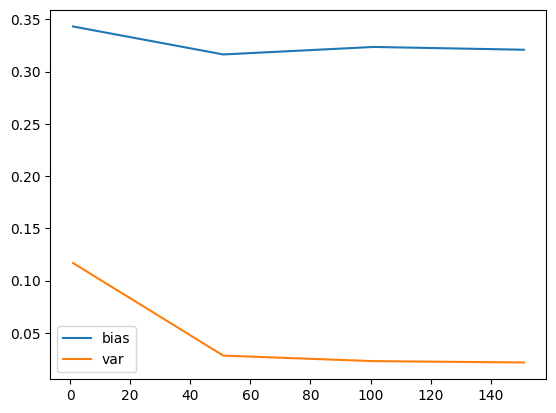

In [ ]:
My_arr2 = My_array.transpose(1, 0)
x = My_arr2[0]
biases = My_arr2[1]
vars = My_arr2[2]

plt.plot(x, biases, label = 'bias')
plt.plot(x, vars, label = 'var')
plt.legend()

#plt.plot()

### a. Также оцените важность признаков. Какие 5 признаков наиболее важны?

In [21]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [22]:
X_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPor

In [26]:
importances = forest.feature_importances_
std = np.std([forest.estimators_[i].feature_importances_ for i in range(len(forest.estimators_))], axis=0)
indexs = [i for i in X_train.columns]
values = zip(indexs, std)

dtype = [('feature_index', 'S30'), ('feature_importance', float)]
a = np.array(list(values), dtype=dtype)

feature_importances_list = np.sort(a, order='feature_importance')[::-1]

feature_names = []
for feature_name, feature_importance in feature_importances_list[:50]:
#    print("feature_name:", feature_name.decode("utf-8"))
#    print("feature_importance:", feature_importance)
    feature_names.append(feature_name.decode("utf-8"))



In [27]:
feature_names

['OverallQual',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'TotalBsmtSF',
 '1stFlrSF',
 'ExterQual',
 'BsmtFinSF1',
 'LotArea',
 'YearBuilt',
 'PoolArea',
 'Neighborhood',
 'GarageYrBlt',
 'TotRmsAbvGrd',
 'GarageCars',
 'LotFrontage',
 'WoodDeckSF',
 'SaleCondition',
 'YearRemodAdd',
 'GarageArea',
 'ScreenPorch',
 'KitchenQual',
 'Fireplaces',
 'BsmtUnfSF',
 'OpenPorchSF',
 'MasVnrArea',
 'LandContour',
 'BsmtQual',
 'LotConfig',
 'MoSold',
 'BsmtExposure',
 'GarageType',
 'MSZoning',
 'OverallCond',
 'BsmtFinType2',
 'LotShape',
 'GarageFinish',
 'YrSold',
 'RoofMatl',
 'Exterior2nd',
 'CentralAir',
 'BsmtHalfBath',
 'BedroomAbvGr',
 'MSSubClass',
 'SaleType',
 'Exterior1st',
 'PavedDrive',
 'EnclosedPorch',
 'HalfBath',
 'Condition2']

### b. Как изменится результат при использовании только 3/5/8 важнейших признаков?

In [ ]:
for i in range(3, 10, 1):
    df2 = df[feature_names[:i]]
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df2, y, test_size=0.3, random_state=1)
    
    forest = RandomForestRegressor(random_state=0,
    #    max_depth=5,
    #    min_samples_leaf=150,          #Явное ограничения
        min_samples_split=15,         #Могут быть листья меньше величины, если сильно меняется информативность
    #    ccp_alpha=0.005,               # выкидываем лишнее (после построения) (prepruning)
    #    min_impurity_decrease=0.003,  # ограничивает по ходу построения дерева (postpruning)
    ####    splitter = "random", # выбрать границу определенным образом threshhold (базовый использует max impurity increase)
    )
    forest.fit(X_train_2, y_train_2)

    print(i, ":", forest.score(X_test_2, y_test_2))

3 : 0.8132618637555001
4 : 0.8164763959359391
5 : 0.8283412760939186
6 : 0.8228000037953093
7 : 0.8230329993718071
8 : 0.8402544819079344
9 : 0.8406817058854308


### c. * покажите разницу между использованием oob_score и кросс-валидации с помощью графиков/таблиц (2 балла со *)

In [ ]:
#df2 = df[feature_names[:3]]


from sklearn.ensemble import RandomForestRegressor
def test (df2):
    rlf = RandomForestRegressor(oob_score=True,random_state=11)

    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df2, y, test_size=0.3, random_state=1)
        
    forest = RandomForestRegressor(random_state=0,oob_score=True,
        #    max_depth=5,
        #    min_samples_leaf=150,          #Явное ограничения
        min_samples_split=15,         #Могут быть листья меньше величины, если сильно меняется информативность
        #    ccp_alpha=0.005,               # выкидываем лишнее (после построения) (prepruning)
        #    min_impurity_decrease=0.003,  # ограничивает по ходу построения дерева (postpruning)
        ####    splitter = "random", # выбрать границу определенным образом threshhold (базовый использует max impurity increase)
        )
    forest.fit(X_train_2, y_train_2)
    ulal = forest.oob_score_

    forest = RandomForestRegressor(random_state=0,oob_score=True,
        #    max_depth=5,
        #    min_samples_leaf=150,          #Явное ограничения
        min_samples_split=15,         #Могут быть листья меньше величины, если сильно меняется информативность
        #    ccp_alpha=0.005,               # выкидываем лишнее (после построения) (prepruning)
        #    min_impurity_decrease=0.003,  # ограничивает по ходу построения дерева (postpruning)
        ####    splitter = "random", # выбрать границу определенным образом threshhold (базовый использует max impurity increase)
        )


    return (np.mean(cross_validate(rlf, X_train_2, y_train_2)['test_score']), ulal)



In [ ]:
a = []
b = []

for i in range(6, 20):
    #print(test(df[feature_names[5:i]]))
    a.append(test(df[feature_names[5:i]])[0])
    b.append(test(df[feature_names[5:i]])[1])

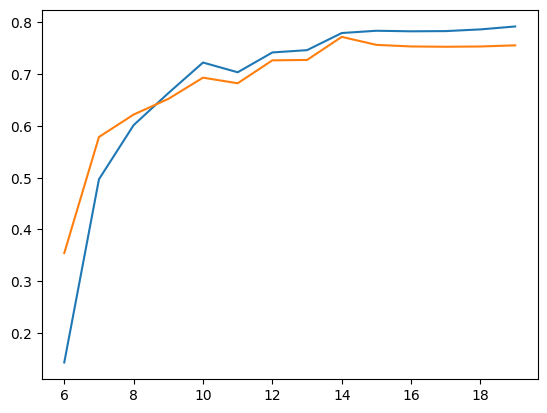

In [ ]:
plt.plot(list(range(6, 20)), a)
plt.plot(list(range(6, 20)), b)


# 4. (*) Обучите случайный лес с помощью “mse”. Покажите разницу в точности на тестовом наборе. На каких примерах разница наиболее заметна? (2 балла)

In [13]:
rf_tree = RandomForestRegressor(random_state=0, n_estimators=50, max_depth=5, min_samples_leaf=5, criterion="squared_error")
rf_tree.fit(X_train, y_train)

y_pred_mse = rf_tree.predict(X_test)
rf_tree.score(X_test, y_test)



0.834365691331235

In [14]:
rf_tree = RandomForestRegressor(random_state=0, n_estimators=50, max_depth=5, min_samples_leaf=5, criterion="absolute_error")
rf_tree.fit(X_train, y_train)

y_pred_mae = rf_tree.predict(X_test)
rf_tree.score(X_test, y_test)



0.8378086613980773

(array([  1.,   0., 323.,   2.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([-12.13936387,  -7.7720313 ,  -3.40469872,   0.96263385,
          5.32996642,   9.697299  ,  14.06463157,  18.43196414,
         22.79929672,  27.16662929,  31.53396186]),
 <BarContainer object of 10 artists>)

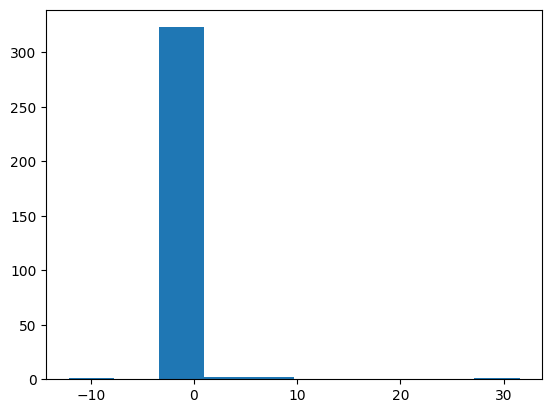

In [15]:
diff = (y_pred_mse - y_pred_mae)/y_pred_mse
df_diff = pd.DataFrame({"diff":diff}) 
plt.hist(df_diff)


In [16]:
marked_index = (df_diff["diff"] > 1) | (df_diff["diff"] < -1)
df_diff[marked_index]

,diff
4,7.084832
27,-1.174141
55,-1.140406
99,-2.035764
100,-1.247226
111,-2.626174
117,-12.139364
141,2.511597
143,1.819304
169,31.533962


In [17]:
df_show = X_test.copy()
df_show["marked"] = 0

df_show.loc[marked_index.values, "marked"] = 1

df_show.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,marked
1299,20,3,75.0,7500,1,3,3,0,4,0,...,0,0,0,0,0,5,2010,8,4,0
575,50,3,80.0,8480,1,3,3,0,4,0,...,102,0,0,0,0,10,2008,0,0,0
1376,30,3,52.0,6292,1,3,0,0,4,0,...,0,0,0,0,0,4,2008,8,4,0
892,20,3,70.0,8414,1,3,3,0,4,0,...,0,0,0,0,0,2,2006,8,4,0
1068,160,4,42.0,3964,1,3,3,0,4,0,...,0,0,0,0,0,6,2006,8,4,1


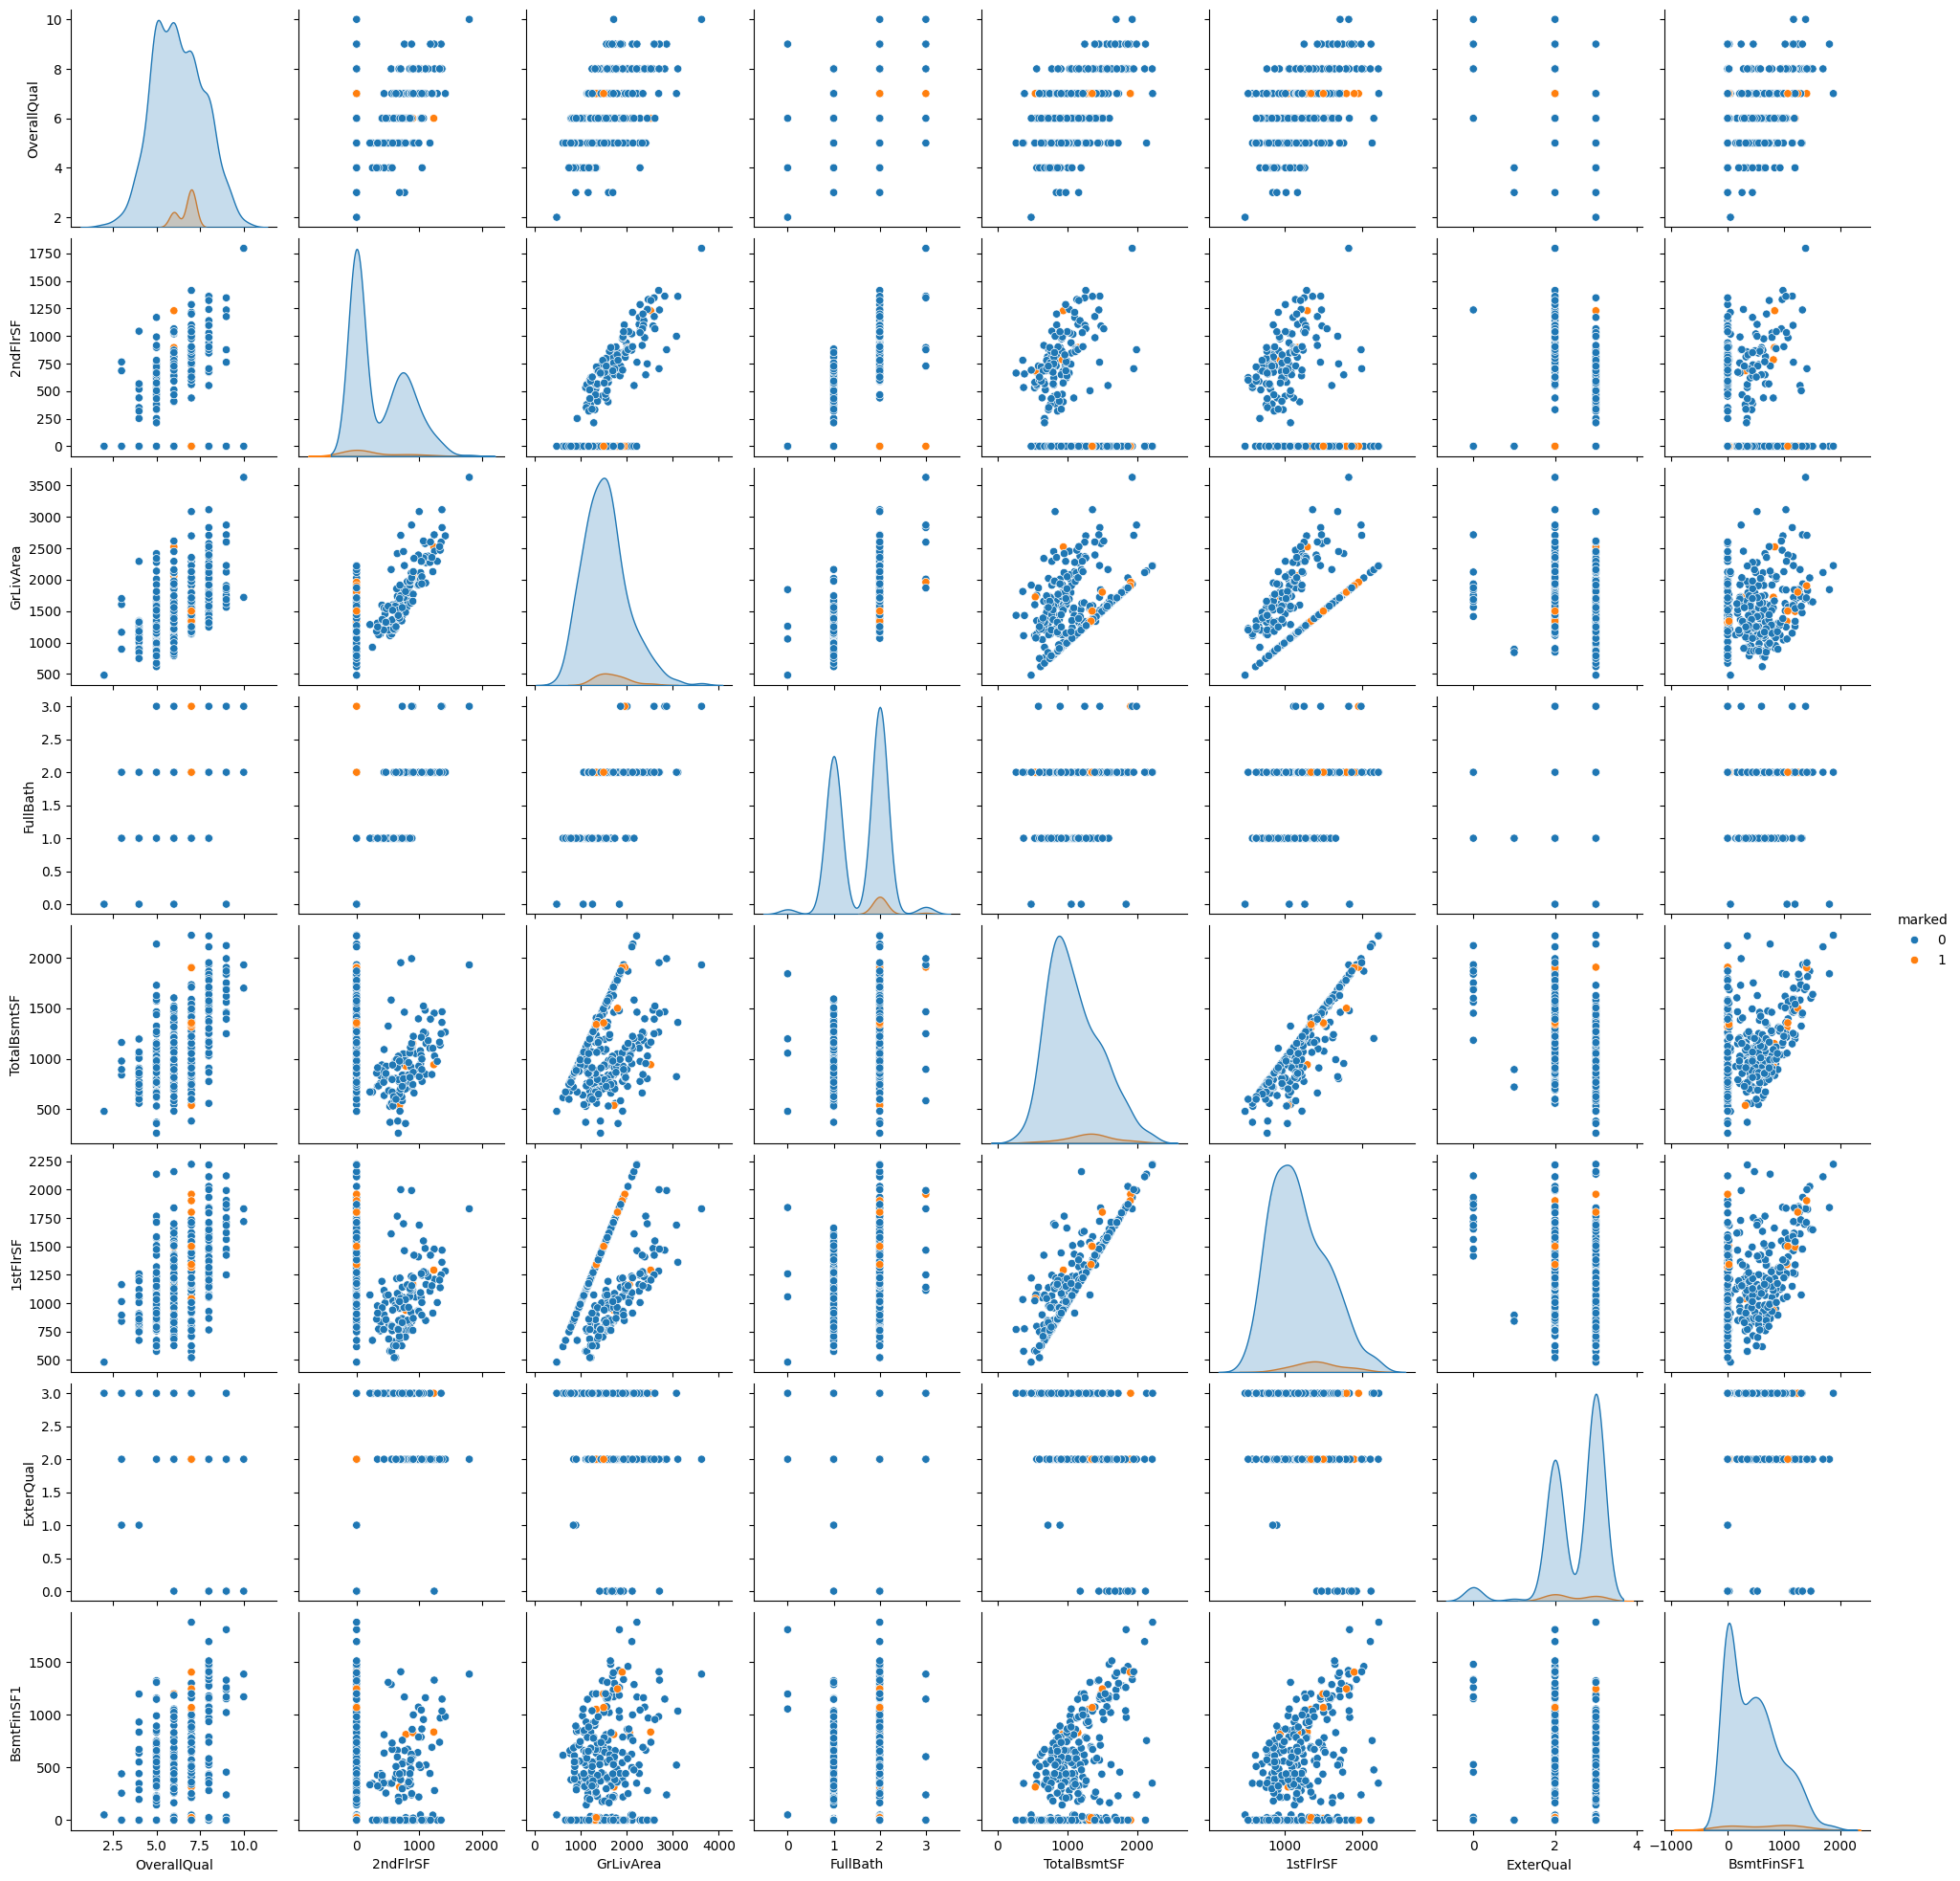

In [30]:
#skip, draw = train_test_split(df_show)
#, palette='pastel'

draw.shape
sns.pairplot(df_show, vars=feature_names[:8], hue='marked')
 
#sns.pairplot(df_show)
#plt.show()

# 5. Повторите шаги из пункта 3 для AdaBoost. Также постройте зависимость точности от глубины дерева. (4 балла)

### a. Также оцените важность признаков. Какие 5 признаков наиболее важны?

In [22]:
import pandas
#import xarray
import numpy as np
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor


tree = DecisionTreeRegressor(max_depth=10, random_state=0)
ada_model= AdaBoostRegressor(estimator=tree, random_state=0)

model= ada_model.fit(X_train, y_train)
#model.feature_importances_

#std = np.std([forest.estimators_[i].feature_importances_ for i in range(len(forest.estimators_))], axis=0)
indexs = [i for i in X_train.columns]
values = zip(indexs, model.feature_importances_)

dtype = [('feature_index', 'S30'), ('feature_importance', float)]
a = np.array(list(values), dtype=dtype)

feature_importances_list = np.sort(a, order='feature_importance')[::-1]

feature_names = []
for feature_name, feature_importance in feature_importances_list[:50]:
    print("feature_name:", feature_name.decode("utf-8"))
    print("feature_importance:", feature_importance)
    feature_names.append(feature_name.decode("utf-8"))

feature_name: OverallQual
feature_importance: 0.38741824924509866
feature_name: 2ndFlrSF
feature_importance: 0.13764274262881018
feature_name: GrLivArea
feature_importance: 0.08659299986397333
feature_name: GarageCars
feature_importance: 0.07197984810062354
feature_name: TotalBsmtSF
feature_importance: 0.04477049945957215
feature_name: BsmtFinSF1
feature_importance: 0.0430155020988065
feature_name: Neighborhood
feature_importance: 0.03188604620818679
feature_name: 1stFlrSF
feature_importance: 0.030930656304674772
feature_name: TotRmsAbvGrd
feature_importance: 0.015231072775163768
feature_name: LotArea
feature_importance: 0.013975120083343435
feature_name: YearBuilt
feature_importance: 0.012315562623091558
feature_name: Fireplaces
feature_importance: 0.012286985958435769
feature_name: GarageYrBlt
feature_importance: 0.011149424478763041
feature_name: LotFrontage
feature_importance: 0.00924283304946415
feature_name: MasVnrArea
feature_importance: 0.008690436228098015
feature_name: WoodDe

### b. Как изменится результат при использовании только 3/5/8 важнейших признаков?

In [27]:
for i in range(3, 10, 1):
    df2 = df[feature_names[:i]]
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df2, y, test_size=0.3, random_state=1)
    
    model= AdaBoostRegressor(estimator=tree, random_state=0)

#    forest = RandomForestRegressor(random_state=0,
    #    max_depth=5,
    #    min_samples_leaf=150,          #Явное ограничения
#        min_samples_split=15,         #Могут быть листья меньше величины, если сильно меняется информативность
    #    ccp_alpha=0.005,               # выкидываем лишнее (после построения) (prepruning)
    #    min_impurity_decrease=0.003,  # ограничивает по ходу построения дерева (postpruning)
    ####    splitter = "random", # выбрать границу определенным образом threshhold (базовый использует max impurity increase)
#    )
    model.fit(X_train_2, y_train_2)

    print(i, ":", model.score(X_test_2, y_test_2))

3 : 0.7762504915217412
4 : 0.7985423390508196
5 : 0.8242911122142915
6 : 0.8409233765019605
7 : 0.8508027762219482
8 : 0.844654549901696
9 : 0.8508365322465793


### c. Также постройте зависимость точности от глубины дерева.

In [29]:
for i in range(1, 10, 1):
    df2 = df.copy() # [feature_names[:i]]
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df2, y, test_size=0.3, random_state=1)
    
    tree = DecisionTreeRegressor(max_depth=i, random_state=0)
    model= AdaBoostRegressor(estimator=tree, random_state=0)
    model.fit(X_train_2, y_train_2)

    print(i, ":", model.score(X_test_2, y_test_2))

1 : 0.5365483956125097
2 : 0.7246638758786397
3 : 0.812248106093464
4 : 0.8406281661375046
5 : 0.8725599666035175
6 : 0.8651357397931813
7 : 0.872856381007233
8 : 0.8608094498159534
9 : 0.8733537398182065


# 6. (*) какова связь между остатками и градиентом? Покажите в свободной форме, на примере (можно использовать формулы + графики/иллюстрации, набор данных взять любой, синтетический или реальный). 5 баллов

Градиентный бустинг рассматривает задачу минимизации эмпирического риска относительно значений гипотезы:

$$
\widehat{\textbf{h}} = argmin_h R(\textbf{h}) = argmin \sum_{i=1}^{N} L(y^{(i)}, h_i)
$$

$$
\widetilde{\textbf{h}}_m = \widetilde{\textbf{h}}_{m-1} - \beta_m \textbf{g}_m
$$

$$
g_{im} =  \left[ \frac{\partial L(y^{(i)}, h(\textbf{x}^{(i)}))}{\partial h(\textbf{x}^{(i)})} \right]
$$

Для функций с постоянным шагом:
$$
\widetilde{h}_m = \widetilde{h}_{m-1} - \nu h_{m}
$$

$$
h_{m} = argmin_h \sum_{i=1}^{N} (-g_{im} - h(\textbf{x}^{(i)}))

$$

В подавляющем большинстве случаев в качестве базовой модели используется дерево решений,

$$
h_m(\textbf{x} ; \theta ) = \sum_{i=1}^{Q_m} w_{km}1_{R_{km}}(x)
$$


Тогда говорят о gradient tree boosting или gradient boosted regression trees (эти термины эквивалентны). Градиентный бустинг предполагает, что для задачи регрессии 
$m$-е дерево сначала строится стандартным образом на остатках от $ \widetilde{h}_{m-1}$, что позволяет построить области $R_{km}$. Затем веса в листьях $w_{km}$ находятся как решение следующей задачи минимизации:

$$
\widehat{w}_{km} = argmin_w \sum_{x^{(i)} \in R_{km}} L(y^{(i)}, \widetilde{h}_{m-1}(\textbf{x}^{(i)}) + w)

$$

В случае квадратичной функции потерь $w$
 будут просто средними остатков в листьях.

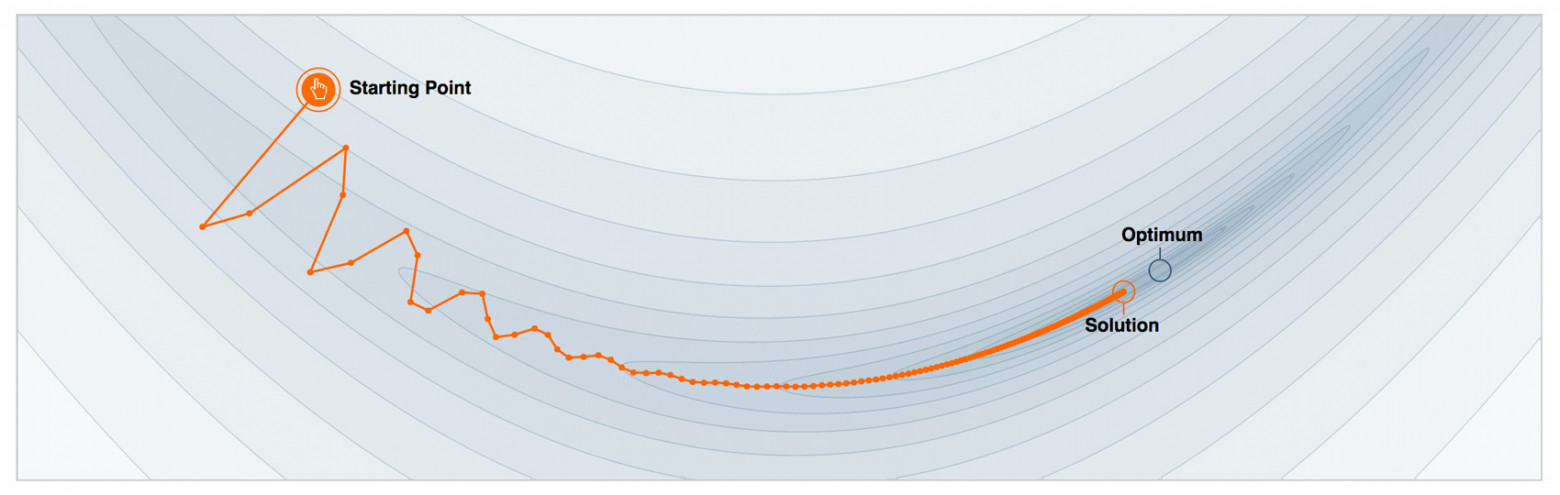

In [109]:
def make_data():
#    x = np.arange(-10, 10, 0.05)
#    y = np.arange(-10, 10, 0.05)
#    xgrid, ygrid = np.meshgrid(x, y)
    X = Y = np.arange(-10, 10, 0.1)
    surface = np.arange(len(X)*len(Y)).reshape(len(X), len(Y)).astype(np.float16)
    xgrid, ygrid = np.meshgrid(X, Y)
#    z = (np.sin(xgrid * -0.1) * np.cos(ygrid * 0.1))

    my_df = pd.DataFrame(columns=['X', 'Y', 'Z'])
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
#            print(x, y)
            surface[i, j] = np.sin((x-2*y) * 0.1) * np.cos(y * 0.1)
#            noise = np.random.normal(-0.5, 0.5, len(X))
#            surface[x] += noise
            my_df.loc[i*len(Y) +j ] = [x, y, surface[i, j]]

    return xgrid, ygrid, surface, my_df #, dataframe


if __name__ == '__main__':
    x, y, z, my_df = make_data()

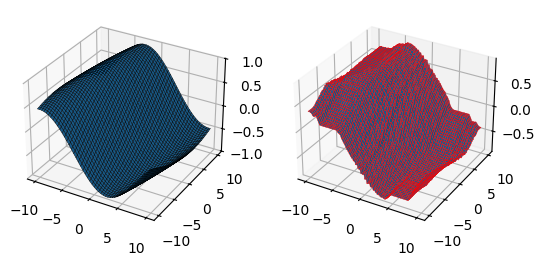

In [160]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')

surf1= ax.plot_surface(x, y, z, edgecolor='k', linewidth=0.3)
    
ax = fig.add_subplot(1, 2, 2, projection='3d')

model= GradientBoostingRegressor(random_state=0, max_depth=2)

model= model.fit(my_df[['X', 'Y']], my_df['Z'].to_numpy())

z_pred = model.predict(my_df[['X', 'Y']])
results = z_pred.reshape(200, 200).astype(np.float16)

surf1= ax.plot_surface(x, y, results, edgecolor='r', linewidth=0.3)
    
plt.show()

In [161]:
my_df_for_lm = my_df[(my_df["X"] < -9) & (my_df["Y"] < -9)]

my_df_for_lm

,X,Y,Z
0,-10.0,-10.0,0.454590
1,-10.0,-9.9,0.455566
2,-10.0,-9.8,0.456299
3,-10.0,-9.7,0.456543
4,-10.0,-9.6,0.456299
...,...,...,...
2006,-9.0,-9.4,0.489746
2007,-9.0,-9.3,0.489746
2008,-9.0,-9.2,0.489258
2009,-9.0,-9.1,0.488281


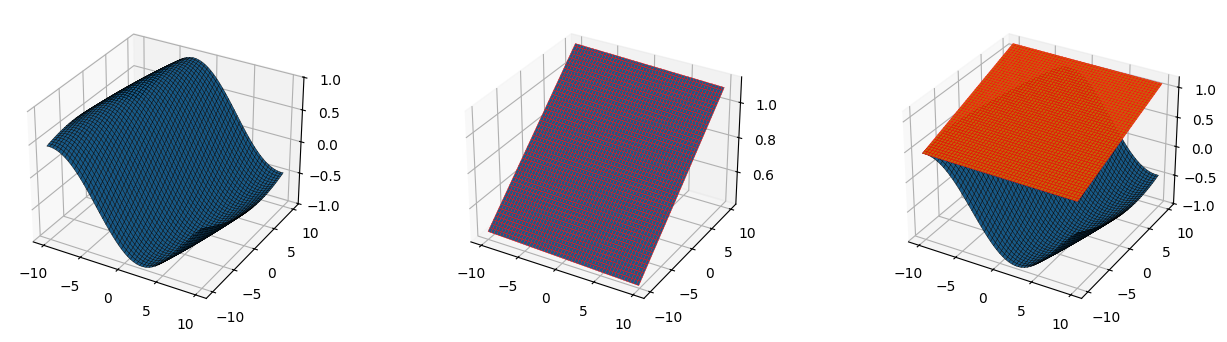

In [171]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

fig = plt.figure()
ax = fig.add_subplot(1, 3, 1, projection='3d')

surf1= ax.plot_surface(x, y, z, edgecolor='k', linewidth=0.3)
    
ax = fig.add_subplot(1, 3, 2, projection='3d')

model= LinearRegression()

model= model.fit(my_df_for_lm[['X', 'Y']], my_df_for_lm['Z'].to_numpy())

z_pred = model.predict(my_df[['X', 'Y']])
results = z_pred.reshape(200, 200).astype(np.float16)

surf2= ax.plot_surface(x, y, results, edgecolor='r', linewidth=0.3)

ax = fig.add_subplot(1, 3, 3, projection='3d')

surf1= ax.plot_surface(x, y, z, edgecolor='k', linewidth=0.3)
surf2= ax.plot_surface(x, y, results, edgecolor='r', linewidth=0.3)

plt.show()

In [97]:
my_df

,X,Y,Z
0,-10.0,-10.0,0.454590
1,-10.0,-9.9,0.455566
2,-10.0,-9.8,0.456299
3,-10.0,-9.7,0.456543
4,-10.0,-9.6,0.456299
...,...,...,...
39995,9.9,9.5,-0.459229
39996,9.9,9.6,-0.459717
39997,9.9,9.7,-0.459717
39998,9.9,9.8,-0.459473


# 7. (*) Повторите шаги из пункта 3 для градиентного бустинга. Проведите анализ зависимости точности от параметров (то, что оценивать, выберите сами. Покажите, как еще можно оценивать такие модели. (5 баллов)

### a. Также оцените важность признаков. Какие 5 признаков наиболее важны?

In [33]:
import pandas
#import xarray
import numpy as np
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import GradientBoostingRegressor


#tree = DecisionTreeRegressor(max_depth=10, random_state=0)
model= GradientBoostingRegressor(random_state=0, max_depth=10)

model= model.fit(X_train, y_train)
#model.feature_importances_

#std = np.std([forest.estimators_[i].feature_importances_ for i in range(len(forest.estimators_))], axis=0)
indexs = [i for i in X_train.columns]
values = zip(indexs, model.feature_importances_)

dtype = [('feature_index', 'S30'), ('feature_importance', float)]
a = np.array(list(values), dtype=dtype)

feature_importances_list = np.sort(a, order='feature_importance')[::-1]

feature_names = []
for feature_name, feature_importance in feature_importances_list[:50]:
    print("feature_name:", feature_name.decode("utf-8"))
    print("feature_importance:", feature_importance)
    feature_names.append(feature_name.decode("utf-8"))

feature_name: OverallQual
feature_importance: 0.6424847059290439
feature_name: GrLivArea
feature_importance: 0.09112503997602925
feature_name: 2ndFlrSF
feature_importance: 0.07527920834509683
feature_name: TotalBsmtSF
feature_importance: 0.02590327209758193
feature_name: BsmtFinSF1
feature_importance: 0.023752174482969582
feature_name: Neighborhood
feature_importance: 0.022424357501451442
feature_name: LotArea
feature_importance: 0.009491325976764706
feature_name: YearBuilt
feature_importance: 0.008989804496833677
feature_name: GarageArea
feature_importance: 0.007961539941043592
feature_name: 1stFlrSF
feature_importance: 0.007503761889738328
feature_name: LotFrontage
feature_importance: 0.006882953522769898
feature_name: LotShape
feature_importance: 0.005876578532071611
feature_name: GarageYrBlt
feature_importance: 0.0057775120373561705
feature_name: OpenPorchSF
feature_importance: 0.005450769493622516
feature_name: GarageType
feature_importance: 0.005245519570332133
feature_name: Over

### b. Как изменится результат при использовании только 3/5/8 важнейших признаков?

In [36]:
for i in range(3, 10, 1):
    df2 = df[feature_names[:i]]
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df2, y, test_size=0.3, random_state=1)
    
    model = GradientBoostingRegressor(random_state=0, max_depth=10)

#    forest = RandomForestRegressor(random_state=0,
    #    max_depth=5,
    #    min_samples_leaf=150,          #Явное ограничения
#        min_samples_split=15,         #Могут быть листья меньше величины, если сильно меняется информативность
    #    ccp_alpha=0.005,               # выкидываем лишнее (после построения) (prepruning)
    #    min_impurity_decrease=0.003,  # ограничивает по ходу построения дерева (postpruning)
    ####    splitter = "random", # выбрать границу определенным образом threshhold (базовый использует max impurity increase)
#    )
    model.fit(X_train_2, y_train_2)

    print(i, ":", model.score(X_test_2, y_test_2))

3 : 0.7359338792244505
4 : 0.7875433569361097
5 : 0.7737451476182255
6 : 0.7703565829647824
7 : 0.767103298583267
8 : 0.785928560772866
9 : 0.7811539858380149


### c.Проведите анализ зависимости точности от параметров (то, что оценивать, выберите сами.

In [50]:
for i in range(1, 11, 1):
    df2.copy()
#    df2 = df[feature_names[:i]]
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df2, y, test_size=0.3, random_state=1)
    
    model = GradientBoostingRegressor(random_state=0, max_depth=10, subsample=i/10)

    model.fit(X_train_2, y_train_2)

    print(i, ":", model.score(X_test_2, y_test_2))

1 : 0.8111065521760713
2 : 0.8316324666828032
3 : 0.8662225471997559
4 : 0.8834821280525984
5 : 0.869332949738454
6 : 0.8596946285734868
7 : 0.8576457820448087
8 : 0.8504469495859039
9 : 0.8222228206691249
10 : 0.7811539858380149


In [51]:
for loss in {"squared_error", "absolute_error", "huber", "quantile"}:
    df2.copy()

    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df2, y, test_size=0.3, random_state=1)
    
    model = GradientBoostingRegressor(random_state=0, max_depth=10, subsample=0.4, loss=loss)

    model.fit(X_train_2, y_train_2)

    print(loss, ":", model.score(X_test_2, y_test_2))

huber : 0.8550351298724468
absolute_error : 0.8720621034826409
quantile : 0.8314952194354113
squared_error : 0.8834821280525984


In [56]:
for depth in range(1, 10):
    df2.copy()

    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df2, y, test_size=0.3, random_state=1)
    
    model = GradientBoostingRegressor(random_state=0, max_depth=depth, subsample=0.4, loss="squared_error")

    model.fit(X_train_2, y_train_2)

    print(depth, ":", model.score(X_test_2, y_test_2))

1 : 0.8334344743985042
2 : 0.8478418083833144
3 : 0.8694426821486441
4 : 0.8708705946763324
5 : 0.8827872855348878
6 : 0.8551457044799667
7 : 0.8738898700293565
8 : 0.8725805189946689
9 : 0.878672907863981
